# Simulation of data

In [469]:
# simulation of data Y = f(X) + epsilon
import scipy.stats as sts
import numpy as np
import seaborn as sns; sns.set(palette='summer')
import matplotlib.pyplot as plt
% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [470]:
a, b = 0, 1 # interval [0, 1]
n = 200 # size of data

# noise simulation
lmbd_int = .8 ** 2 # medium noise level
norm_rv = sts.norm(2, 0.4)
sigma = np.diag(lmbd_int * np.sort(norm_rv.rvs(n) ** 2)) # covariance matrix of epsilon
epsilon = sts.multivariate_normal(cov=sigma).rvs()

$$
f(x) = c_0 + \sum_{j = 1}^{\lfloor n / 2 \rfloor} c_{2j - 1} \sin(2 \pi j x) + c_{2j} \cos(2 \pi j x),
$$

In [471]:
# f(X)
norm_rv = sts.norm(0, 1)
basis_coef = np.zeros(n + 1)
basis_coef[:10] = norm_rv.rvs(10)
basis_coef[10:-1] = norm_rv.rvs(n - 10) / np.array([(j - 10) ** 2 for j in range(11, n + 1)])

def f(x):
    res = basis_coef[0]
    for j in range(1, n // 2 + 1):
        res += basis_coef[2 * j - 1] * np.sin(2 * np.pi * j * x / (b - a))
        res += basis_coef[2 * j] * np.cos(2 * np.pi * j * x / (b - a))
    return res

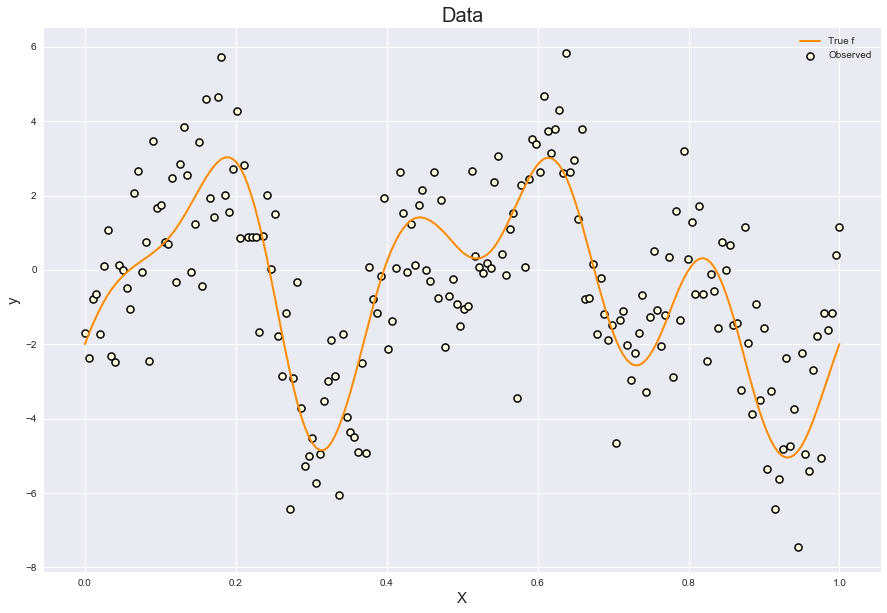

In [472]:
X = np.linspace(a, b, n)
y = f(X) + epsilon
plt.figure(figsize=(15, 10))
plt.scatter(X, y, label='Observed', s=50, edgecolors='black', c='lightyellow', lw=1.5)
plt.plot(X, f(X), label='True f', lw=2, c='darkorange')
plt.title('Data', fontsize=20)
plt.xlabel('X', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.legend()

# B-splines

In [473]:
from scipy.interpolate import *

Let us plot few b-splines.

Text(0.5,0,'x')

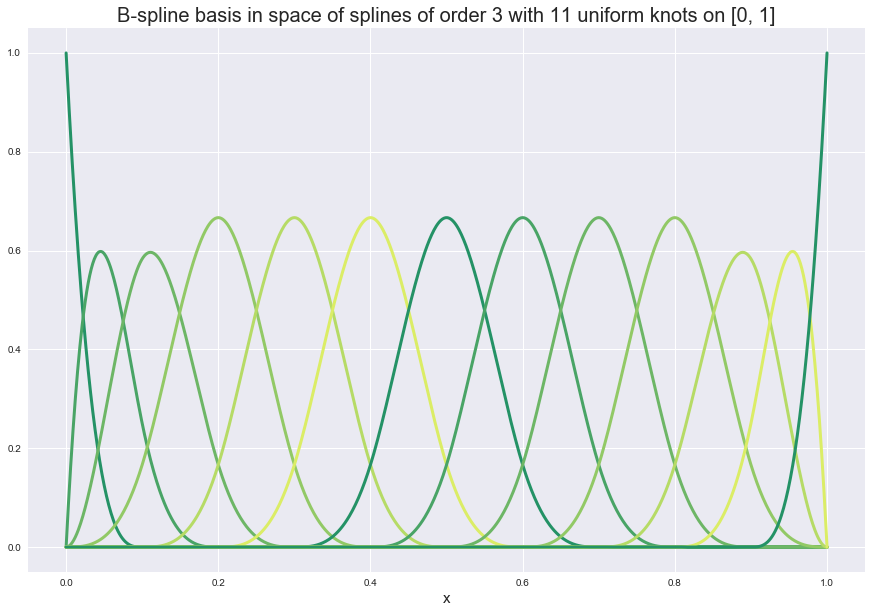

In [474]:
plt.figure(figsize=(15, 10))
x_for_plot = np.linspace(0, 1, 1000)

m = 3 # order of b-splines
K = 11 # number of knots
knots = np.concatenate((np.zeros(m), np.linspace(0, 1, K), np.ones(m)))
#knots = np.concatenate((np.zeros(m + 1) - .1, np.linspace(0, 1, K), np.ones(m + 1) + .1))
coef = np.identity(K + m - 1) # each row is coefficients of linear combination of b-splines
for c in coef:
    bspl = BSpline(t=knots, c=c, k=m)
    plt.plot(x_for_plot, bspl(x_for_plot), lw=3)
plt.title('B-spline basis in space of splines of order 3 with 11 uniform knots on [0, 1]', fontsize=20)
plt.xlabel('x', fontsize=15)

# Smoothing splines

Our goal is to find the solution to the following problem

$$
argmin_{\ f} \sum_{i=1}^n (y_i - f(x_i))^2 + \int\limits_0^1 \left|\ f^{((q + 1) / 2)}(x) \right|^2\ dx.
$$

It is known that the solution is the spline of order $q$ with knots $\{x_i\}_{i=1}^n$, but how to calculate it?

Since the set of all splines of order $q$ with knots in $x_i$ is a linear space, and b-splines form a basis in this space, we can seek the solution in form

$$
f(x) = \sum_{k = 1}^{q + n - 1} \theta_k b_{k, q}(x)
$$

In [475]:
q = 3 # order of smoothing spline
knots = np.concatenate((np.zeros(m), X, np.ones(m))) # data points + boundary knots
delta = (b - a) / (n - 1)
coef = np.identity(n + q - 1)

# (j + 1)-th basis function (j = 0, ..., n + q - 2)
def bspline(x, j):
    bspl = BSpline(t=knots, c=coef[j, :], k=q)
    return bspl(x)

# support of b_j
def supp(j):
    if j + 1 < n:
        return max(a, X[j + 1] - 4 * delta), X[j + 1]
    else:
        return b - (q - (j + 1 - n)) * delta, b
    
# s-th derivative of b_j
def der(x, j, s):
    return spalde(x, (knots, coef[j, :], q))[s]

In [476]:
# Initialization of matrix B, B_ij = b_j(x_i)
B = np.zeros((n, n + q - 1)) 
for j in range(n + q - 1):
    B[:, j] = bspline(X, j)

$$
\Omega_{ij} = \int\limits_{0}^1 b_i^{((q + 1)/2)}(x) b_j^{((q + 1)/2)}(x)\ dx
$$

In [477]:
# Initialization of matrix Omega
from scipy.integrate import quad

Omega = np.zeros((n + q - 1, n + q - 1))
s = int((q + 1) / 2)
for i in range(n + q - 1):
    for j in range(max(0, i - 3), i + 1):
        Omega[i, j] = quad(lambda x: der(x, i, s) * der(x, j, s), a=supp(i)[0], b=supp(i)[1])[0]
        
Omega = Omega + Omega.T - np.diag(np.diag(Omega))    

$$
\theta = (B^T B + \lambda \Omega)^{-1} B^T y
$$

In [478]:
from numpy.linalg import inv

lmbd = 0.5*1e-4 # smoothing parameter (adjusting)
theta = np.dot(inv(np.dot(B.T, B) + lmbd * Omega), np.dot(B.T, y)) # coefficients of smoothing spline
my_smoothing_spline = np.dot(B, theta) # smoothing spline at data points

In [483]:
# let's compare our spline with scipy's spline
spl = UnivariateSpline(X, y, s=450)
scipy_spline = spl(X)

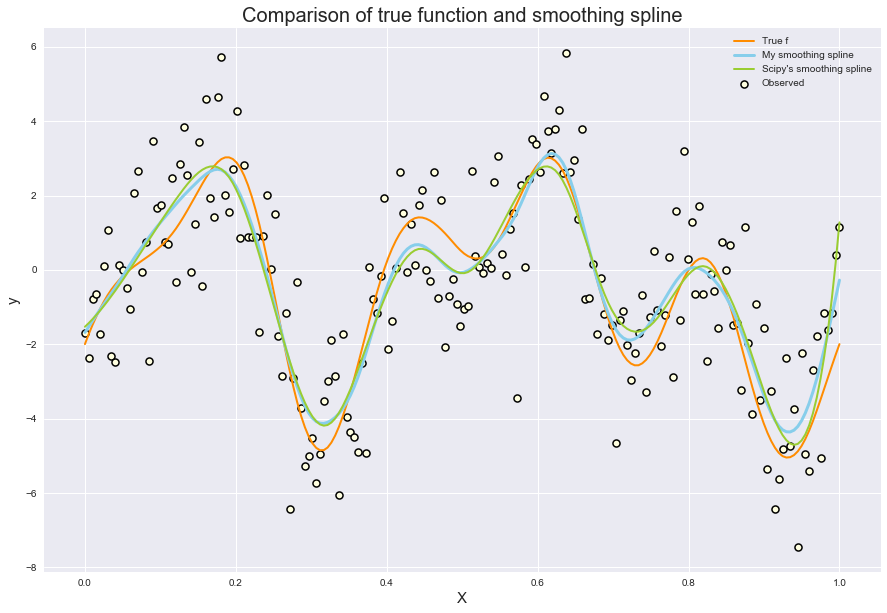

In [484]:
plt.figure(figsize=(15, 10))
plt.scatter(X, y, label='Observed', s=50, edgecolors='black', c='lightyellow', lw=1.5)
plt.plot(X, f(X), label='True f', lw=2, c='darkorange')
plt.plot(X, my_smoothing_spline, label='My smoothing spline', lw=3, c='skyblue')
plt.plot(X, scipy_spline, label="Scipy's smoothing spline", lw=2, c='yellowgreen')
plt.title('Comparison of true function and smoothing spline', fontsize=20)
plt.xlabel('X', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.legend()